In [1]:
#!pip install spectral

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

#from spectral import imshow, view_cube
#import spectral.io.envi as envi


## Inforamções aleatórias

usar so antigeno, controle e interferencia (outras coisas que nao é o antigeno)

coluna 1 e 2: coordenada da imagem
coluna 3: comprimento de onda
coluna 4: intensidade do elemento

plotar intensidade x comprimento: espectro


para cada pixel tem um array que é o espectro. E cada espectro tem 1014 comprimento de ondas.

se parar no comprimento de onda e olha os dados (os pixels) vemos a imagem


cada espectro tem 1014 linhas. com 441 espectros (21 linhas x 21 colunas)


olhar para comprimento de onda de onde esta o pico.

espectro medio

o objeto de dado é o cubo. dentro daquele cubo temos que saber quais atributos são importantes

ver imagem basta fixar os espectros e percorrer as coordenadas 

1079, cm^-1, pico de tudo

### Lendo os arquivos do diretório

In [2]:
antigenPath = 'dados/sers/antigen'
controlPath = 'dados/sers/control'
interferingPath = 'dados/sers/interfering'



def validate_data_shape(data, expected_num_spectra, points_per_spectrum, file_name):
    if not data.shape[0] == expected_num_spectra * points_per_spectrum:
        raise Exception(
            'Error in file {}. Number of spectra ({}) unexpected.'.format(file_name, data.shape[0])
        )


def process_copy(data, spec_number, points_per_spectrum, is_initial_spec, previous_raman_shift, file_name):
    spec_start = spec_number * points_per_spectrum
    spec_end = (spec_number + 1) * points_per_spectrum
    position_x = int(data[spec_start, 0])
    position_y = int(data[spec_start, 1])

    if is_initial_spec:
        current_raman_shift = data[spec_start:spec_end, -2]
        is_initial_spec = False
    else:
        if not np.array_equal(data[spec_start:spec_end, -2], previous_raman_shift):
            raise Exception(
                'Error in file {}, spec number {}. Raman Shift axis is different.'.format(file_name, spec_number)
            )
        else:
            current_raman_shift = data[spec_start:spec_end, -2]

    return spec_start, spec_end, position_x, position_y, current_raman_shift, is_initial_spec


def create_dataframe_from_files(file_list):
    spectra_data = []
    positions_data = []
    is_initial_spec = True
    num_spectra = 441
    points_per_spectrum = 1014
    map_counter = 0
    previous_raman_shift = None

    for file_name in file_list:
        data = np.loadtxt(file_name, delimiter="\t")
        validate_data_shape(data, num_spectra, points_per_spectrum, file_name)

        num_specs = data.shape[0] / points_per_spectrum
        print(file_name, num_specs)

        for spec_number in range(int(num_specs)):
            spec_start, spec_end, position_x, position_y, previous_raman_shift, is_initial_spec = process_copy(
                data, spec_number, points_per_spectrum, is_initial_spec, previous_raman_shift, file_name
            )

            spectra_data.append(data[spec_start:spec_end, -1])
            positions_data.append([position_x, position_y, spec_number, map_counter])

        map_counter += 1

    df_spectra = pd.DataFrame(data=spectra_data, columns=data[spec_start:spec_end, -2])
    df_positions = pd.DataFrame(data=positions_data, columns=['x', 'y', 'spec_number', 'map'])
    df_combined = pd.concat([df_spectra, df_positions], axis=1)
    df_combined = df_combined.sort_values(by=['map', 'spec_number'], ignore_index=True)
    return df_combined

def create_datasets(antigen_path, control_path, interfering_path):
    antigen_files = next(os.walk(antigen_path), (None, None, []))[2]
    control_files = next(os.walk(control_path), (None, None, []))[2]
    interfering_files = next(os.walk(interfering_path), (None, None, []))[2]

    antigen_data = create_dataframe_from_files([os.path.join(antigen_path, file_name) for file_name in antigen_files])
    control_data = create_dataframe_from_files([os.path.join(control_path, file_name) for file_name in control_files])
    interfering_data = create_dataframe_from_files([os.path.join(interfering_path, file_name) for file_name in interfering_files])

    return antigen_data, control_data, interfering_data


def merge_datasets(antigen_data, control_data, interfering_data):
    # Add a new column with values 0 for control, 1 for antigen, and 2 for interfering
    antigen_data['target'] = 1
    control_data['target'] = 0
    interfering_data['target'] = 2

    # Concatenate the three dataframes vertically
    merged_data = pd.concat([antigen_data, control_data, interfering_data], axis=0)
    merged_data = merged_data.reset_index(drop = True)

    return merged_data

antigen_data, control_data, interfering_data = create_datasets(antigenPath, controlPath, interferingPath)
raw_data = merge_datasets(antigen_data, control_data, interfering_data)
#raw_data = create_datasets(antigenPath, controlPath, interferingPath)
raw_data

dados/sers/antigen\antigeno1.txt 441.0
dados/sers/antigen\antigeno10.txt 441.0
dados/sers/antigen\antigeno11.txt 441.0
dados/sers/antigen\antigeno12.txt 441.0
dados/sers/antigen\antigeno13.txt 441.0
dados/sers/antigen\antigeno14.txt 441.0
dados/sers/antigen\antigeno15.txt 441.0
dados/sers/antigen\antigeno16.txt 441.0
dados/sers/antigen\antigeno2.txt 441.0
dados/sers/antigen\antigeno3.txt 441.0
dados/sers/antigen\antigeno4.txt 441.0
dados/sers/antigen\antigeno5.txt 441.0
dados/sers/antigen\antigeno6.txt 441.0
dados/sers/antigen\antigeno7.txt 441.0
dados/sers/antigen\antigeno8.txt 441.0
dados/sers/antigen\antigeno9.txt 441.0
dados/sers/control\controle1.txt 441.0
dados/sers/control\controle10.txt 441.0
dados/sers/control\controle11.txt 441.0
dados/sers/control\controle12.txt 441.0
dados/sers/control\controle13.txt 441.0
dados/sers/control\controle14.txt 441.0
dados/sers/control\controle15.txt 441.0
dados/sers/control\controle16.txt 441.0
dados/sers/control\controle17.txt 441.0
dados/sers

,1611.19,1610.19,1609.18,1608.18,1607.17,1606.17,1605.16,1604.16,1603.15,1602.14,...,476.105,474.84,473.574,472.308,471.042,x,y,spec_number,map,target
0,1971.64,2113.54,2145.43,2147.46,2134.56,2268.41,2310.19,2478.76,2607.48,2793.30,...,855.849,879.351,883.085,853.242,892.524,-10,-10,0,0,1
1,2061.26,2096.11,2093.17,2199.71,2214.17,2273.38,2404.69,2446.44,2649.73,2818.15,...,873.638,865.518,875.183,872.993,904.372,-10,-9,1,0,1
2,2043.83,2036.36,2080.72,2149.95,2176.85,2328.10,2327.60,2516.05,2649.73,2778.39,...,828.177,887.255,902.841,872.993,849.083,-10,-8,2,0,1
3,2001.51,2041.34,2068.28,2102.67,2216.65,2233.59,2322.63,2545.88,2595.05,2828.09,...,855.849,859.590,867.281,916.445,922.143,-10,-7,3,0,1
4,2031.38,2098.60,2120.55,2192.25,2236.56,2365.41,2302.73,2458.87,2652.22,2808.21,...,897.356,907.016,918.646,928.295,876.727,-10,-6,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20281,1540.96,1687.84,1754.68,1716.97,1826.07,1738.62,1927.23,1894.50,1983.57,2154.62,...,679.935,650.127,673.674,647.832,649.647,10,6,436,9,2
20282,1610.67,1635.56,1692.45,1712.00,1763.87,1870.44,1780.51,1929.30,1963.69,2162.07,...,658.193,695.576,681.576,635.981,657.545,10,7,437,9,2
20283,1690.33,1672.90,1699.92,1754.30,1796.21,1882.88,1932.21,1966.60,2025.83,2109.89,...,636.451,661.983,663.796,709.060,649.647,10,8,438,9,2
20284,1700.29,1692.82,1687.48,1684.62,1726.55,1798.31,1894.91,1929.30,2035.77,2157.10,...,677.959,669.887,661.820,651.782,681.241,10,9,439,9,2


In [3]:
def calculate_difference(df_out, out_1):
    diff = 0.0
    n_spec = len(out_1)

    for i in range(n_spec):
        spec_exp = np.array(out_1[i])
        spec_raw = df_out.iloc[i, :-5].values
        diff += np.sum(spec_exp - spec_raw)

    return diff


def count_per_class_and_map(df_out):
    count = df_out.groupby(['target', 'map'])['map'].count()
    return count


# Example usage:
count = count_per_class_and_map(raw_data)
count

target  map
0       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
        10     441
        11     441
        12     441
        13     441
        14     441
        15     441
        16     441
        17     441
        18     441
        19     441
1       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
        10     441
        11     441
        12     441
        13     441
        14     441
        15     441
2       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
Name: map, dtype: int64

In [4]:
def countValues(array):
    return pd.DataFrame(array.value_counts())

targets = raw_data.iloc[:,-1]
countValues(targets)

,target
0,8820
1,7056
2,4410


In [5]:
columns = raw_data.columns
countValues(columns)

,0
1611.19,1
871.124,1
886.279,1
885.115,1
883.951,1
...,...
1252.82,1
1251.74,1
1250.66,1
1249.58,1


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20286 entries, 0 to 20285
Columns: 1019 entries, 1611.19 to target
dtypes: float64(1014), int64(5)
memory usage: 157.7 MB


In [7]:
## 21 x 21 x 1014 = 441 (number of waves) x 1014 (lenght of a wave)
def filter_dataframe(df, condition_column, condition_value):
    filtered_df = df[df[condition_column] != condition_value]
    #remaining_df = df[df[condition_column] == condition_value]
    return filtered_df, df

raw_data, remaining_raw_data = filter_dataframe(raw_data, 'target', 2)
raw_data

,1611.19,1610.19,1609.18,1608.18,1607.17,1606.17,1605.16,1604.16,1603.15,1602.14,...,476.105,474.84,473.574,472.308,471.042,x,y,spec_number,map,target
0,1971.64,2113.54,2145.43,2147.46,2134.56,2268.41,2310.19,2478.76,2607.48,2793.30,...,855.849,879.351,883.085,853.242,892.524,-10,-10,0,0,1
1,2061.26,2096.11,2093.17,2199.71,2214.17,2273.38,2404.69,2446.44,2649.73,2818.15,...,873.638,865.518,875.183,872.993,904.372,-10,-9,1,0,1
2,2043.83,2036.36,2080.72,2149.95,2176.85,2328.10,2327.60,2516.05,2649.73,2778.39,...,828.177,887.255,902.841,872.993,849.083,-10,-8,2,0,1
3,2001.51,2041.34,2068.28,2102.67,2216.65,2233.59,2322.63,2545.88,2595.05,2828.09,...,855.849,859.590,867.281,916.445,922.143,-10,-7,3,0,1
4,2031.38,2098.60,2120.55,2192.25,2236.56,2365.41,2302.73,2458.87,2652.22,2808.21,...,897.356,907.016,918.646,928.295,876.727,-10,-6,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15871,2320.16,2412.27,2454.06,2525.69,2557.49,2499.73,2722.99,2841.74,3037.50,3265.48,...,1081.180,1027.560,1084.590,1098.150,1099.860,10,6,436,19,0
15872,2392.35,2447.12,2481.44,2528.18,2599.78,2636.53,2747.86,2881.52,3062.36,3307.72,...,1087.110,1074.980,1078.670,1165.310,1147.250,10,7,437,19,0
15873,2367.46,2374.93,2464.01,2627.71,2559.97,2671.35,2805.06,2881.52,3052.41,3258.02,...,1065.360,1106.600,1064.840,1113.950,1131.450,10,8,438,19,0
15874,2367.46,2442.14,2526.24,2538.13,2629.63,2614.14,2785.16,2916.33,3022.59,3287.84,...,1083.150,1041.390,1070.770,1110.000,1168.970,10,9,439,19,0


## Sampling ??

In [8]:
import statsmodels.stats.power as smp

def powerAnalysis(df, effect_size, alpha, power, alternative='two-sided'):
    """
    Calculates the sample size required for each group in a pandas DataFrame
    to achieve a desired level of statistical power.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    effect_size (float): The standardized effect size to be detected.
    alpha (float): The significance level of the test.
    power (float): The desired level of statistical power.
    alternative (str): The alternative hypothesis for the test ('two-sided', 'larger', or 'smaller').

    Returns:
    pandas.DataFrame: A DataFrame containing the sample size required for each group to achieve the desired level of power.
    """

    # Determine the number of groups and observations per group
    num_groups = df.shape[1]
    num_obs = df.shape[0]

    # Calculate the sample size required for each group
    sample_sizes = []
    for i in range(num_groups):
        #print(effect_size, num_groups)
        effect_size_i = effect_size / (num_groups ** 0.5)  # Bonferroni correction
        sample_size_i = smp.tt_ind_solve_power(effect_size=effect_size_i, nobs1=None, alpha=alpha, power=power, ratio=1, alternative=alternative)
        sample_sizes.append(sample_size_i)

    # Convert the sample sizes to integers and return as a DataFrame
    sample_sizes = [int(round(size)) for size in sample_sizes]
    result = pd.DataFrame({'Sample Size': sample_sizes}, index=df.columns)

    return result


alpha = 0.05
power = 0.8
test = 'two-sided'  # Specify the desired statistical test
X = raw_data.drop(['x','y','spec_number','map', 'target'], axis = 1)
#print(X.dtypes)
sample_size = powerAnalysis(X, effect_size=0.5, alpha=0.05, power=0.8, alternative='two-sided')
sample_size

,Sample Size
1611.190,63671
1610.190,63671
1609.180,63671
1608.180,63671
1607.170,63671
...,...
476.105,63671
474.840,63671
473.574,63671
472.308,63671


# Data Visualization

## Signal visualization

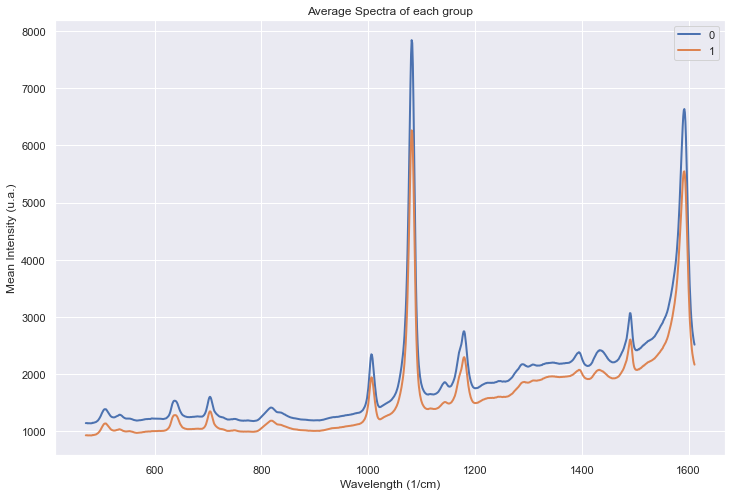

In [9]:
def plotParallelCoordinates(df, title, xlabel, ylabel, target = 'target', colors = ['red', 'blue', 'green']):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,15))
    new_df = df.copy()
    pd.plotting.parallel_coordinates(frame = new_df, class_column = target, ax = ax, color = colors)
    ax.set(title = title,
           xlabel = xlabel,
           ylabel = ylabel)
    plt.xticks(rotation = 45, fontsize = 10)
    #ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
    plt.show()



def plotSersSignal(dataframe):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(16,12))

    target_column = "target"
    columns = dataframe.columns.to_list()
    columns.remove(target_column)

    dataframe_melted = dataframe.melt(id_vars=target_column, value_vars=columns, var_name="Wavelength (1/cm)", value_name="Intensity (u.a.)")
    sns.lineplot(data=dataframe_melted, x="Wavelength (1/cm)", y="Intensity (u.a.)", hue=target_column, markers=True)

    plt.xlabel('Wavelength (1/cm)')
    plt.ylabel('Intensity (u.a.)')
    plt.title('SERS Signal')
    plt.legend()
    plt.xticks(rotation=45)  # Set x-axis ticks to go from 50 to 50 values
    #plt.tight_layout()
    plt.show()
    
def plotAverageSpectra(dataframe):
    # Exclude the "target" column
    data = dataframe.drop("target", axis=1)
    
    # Group the dataframe by the "target" column
    grouped_data = dataframe.groupby("target")
    
    # Set up the plot
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get the column names for plotting
    columns = data.columns
    
    # Iterate over each group
    for group_name, group_data in grouped_data:
        # Calculate the average of each column within the group
        average_spectrum = group_data.iloc[:, :-1].mean(axis=0)        
        # Plot the average spectrum as a line graph
        sns.lineplot(x=columns, y=average_spectrum, label=group_name, linewidth=2)
    
    # Set the x and y labels, title, and legend
    plt.xlabel('Wavelength (1/cm)')
    plt.ylabel('Mean Intensity (u.a.)')
    plt.title('Average Spectra of each group')
    plt.legend()
    
    # Display the plot
    plt.show()

def plotMultipleSersSignals(dataframe):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 8))

    for index, row in dataframe.iterrows():
        signal = row.drop("target")  # Exclude the "target" column
        sns.lineplot(x=signal.columns, y=signal.values, label=row["target"], linewidth=2)

    plt.xlabel('Points')
    plt.ylabel('Intensity')
    plt.title('Multiple SERS Signals')
    plt.legend(title="Target")
    plt.show()


## fazer essa funcao com uma power analysis!!!!!!! - tem resultado significativoe diminui tempo
X = raw_data.drop(['x','y','spec_number','map'], axis = 1)
#plotMultipleSersSignals(X)
plotAverageSpectra(X)

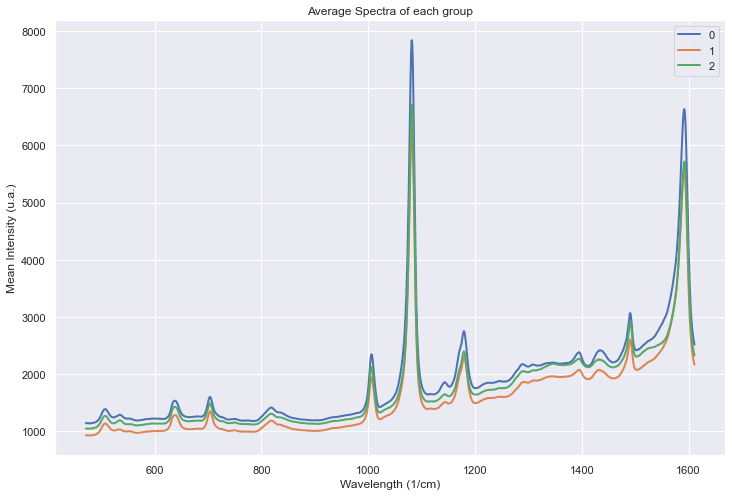

In [10]:
X2 = remaining_raw_data.drop(['x','y','spec_number','map'], axis = 1)
plotAverageSpectra(X2)

## Map visualization

C:\Users\Lucas\AppData\Local\Temp\ipykernel_19056\2585280290.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size=fs_ticklabels)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19056\2585280290.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=fs_ticklabels)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19056\2585280290.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticks(), fontsize=fs_axeslabels)


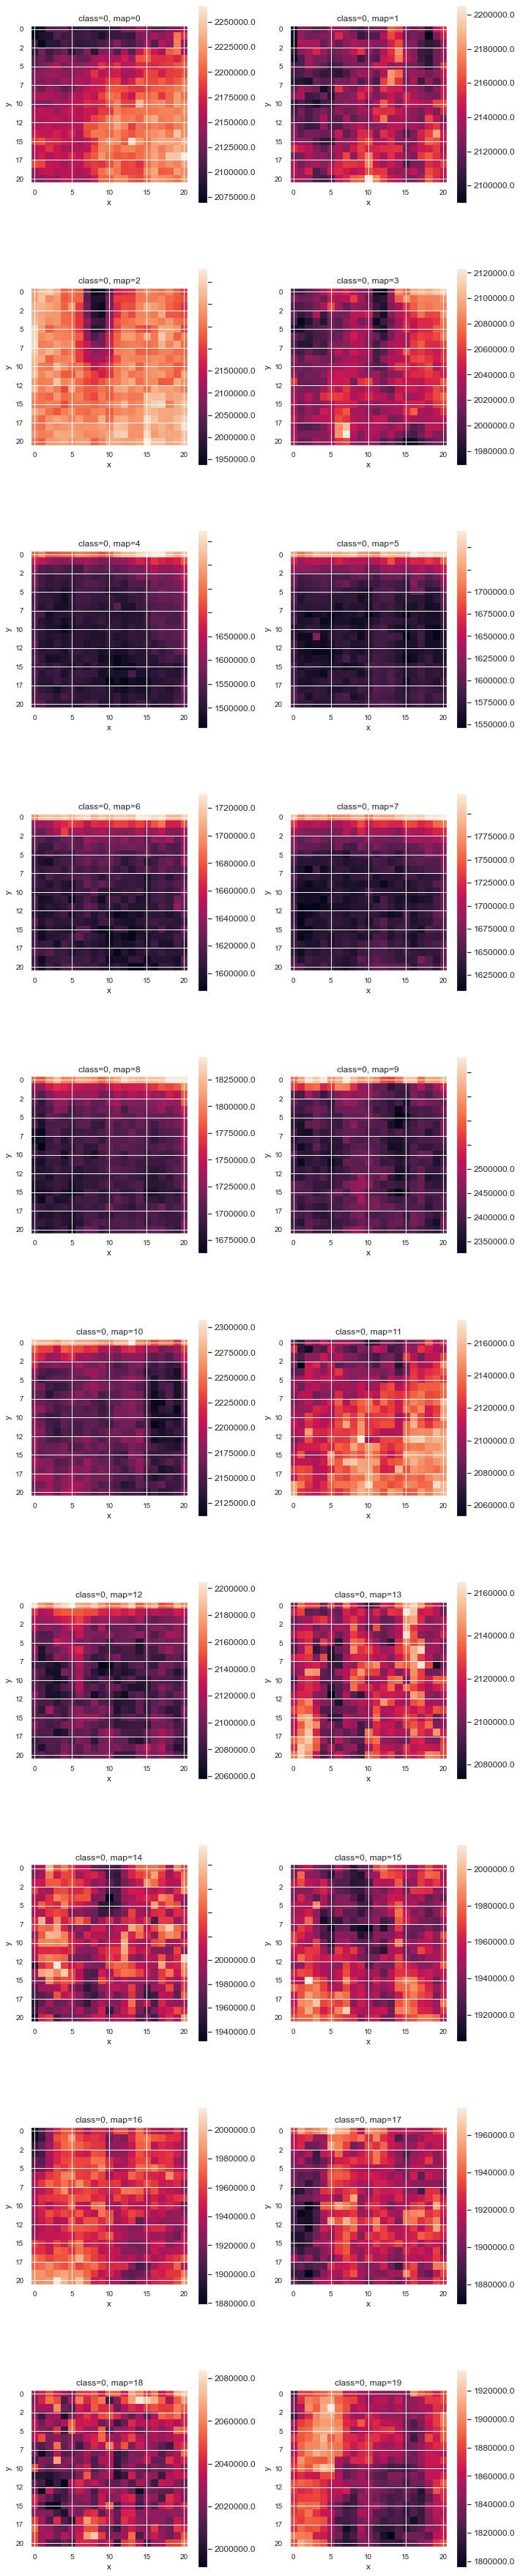

In [11]:
import math
from matplotlib.ticker import FuncFormatter

def plotSERSMaps(df, dim, target_class):
    unique_maps = df.loc[df['target'] == target_class, 'map'].unique()
    
    n_rows = math.ceil(len(unique_maps) / 2)  # Number of rows in the subplot grid
    n_cols = 2  # Number of columns in the subplot grid (set to 2 for 2 maps per row)
    
    figsize = (10, 5 * n_rows)  # Adjust the figure size based on the number of rows
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D axes array into a 1D array
    
    fs_ticklabels = 10  # Define the font size for tick labels
    fs_axeslabels = 12  # Define the font size for axes labels
    
    for i, mp in enumerate(unique_maps):
        ax = axes[i]  # Get the corresponding subplot for the map
        subset = df.loc[(df['target'] == target_class) & (df['map'] == mp)]
        
        if subset.empty:
            ax.axis('off')  # Hide the empty subplot if there is no data
            continue
        
        mi = subset.iloc[:, :-5].sum(axis=1).values.reshape(dim, dim)  # Modify this line based on your desired pixel calculation
        
        im = ax.imshow(mi)
        ax.set_title(f'class={target_class}, map={mp}')
        cb = plt.colorbar(im, shrink=0.825, ax=ax)
        ax.set_xticklabels(ax.get_xticks(), size=fs_ticklabels)
        ax.set_yticklabels(ax.get_yticks(), size=fs_ticklabels)
        ax.set_xlabel('x', fontsize=fs_axeslabels)
        ax.set_ylabel('y', fontsize=fs_axeslabels)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
        cb.ax.set_yticklabels(cb.ax.get_yticks(), fontsize=fs_axeslabels)
    
    # Hide any extra subplots if the number of maps is not a multiple of 2
    for j in range(len(unique_maps), n_rows * n_cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

    
dim = 21  # Define the number of pixels per row/column
plotSERSMaps(raw_data, dim, 0)


C:\Users\Lucas\AppData\Local\Temp\ipykernel_19056\2585280290.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size=fs_ticklabels)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19056\2585280290.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=fs_ticklabels)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19056\2585280290.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticks(), fontsize=fs_axeslabels)


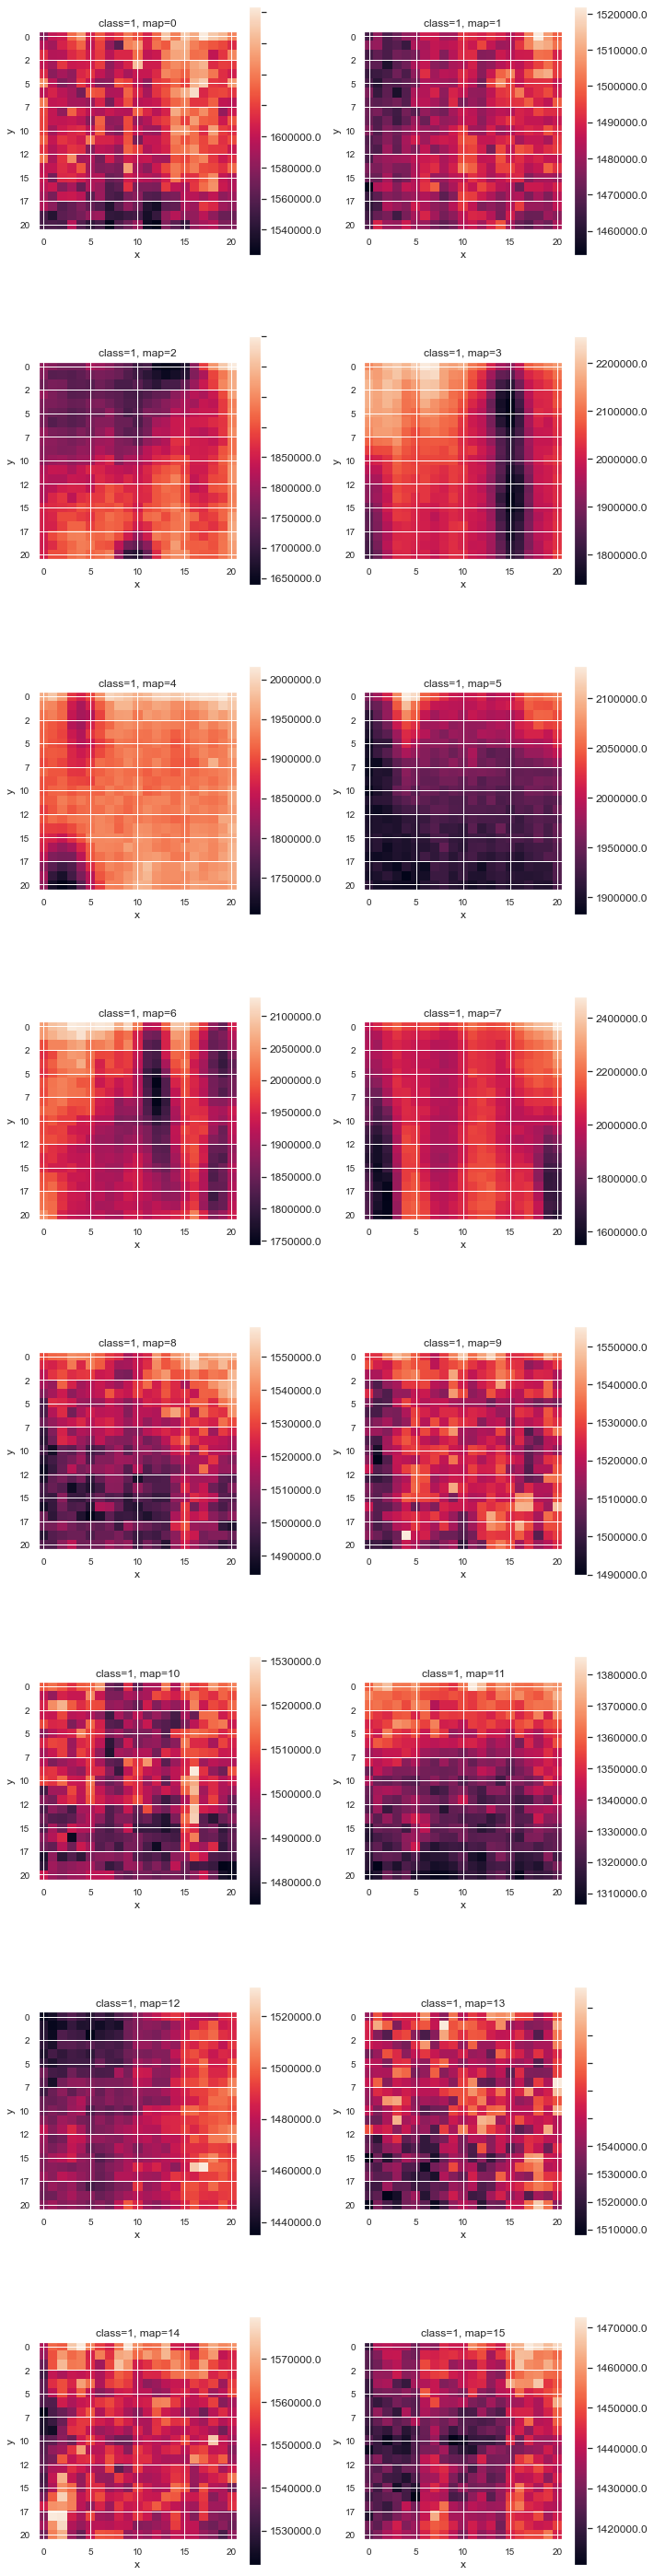

In [12]:
plotSERSMaps(raw_data, dim, 1)

## Box plots

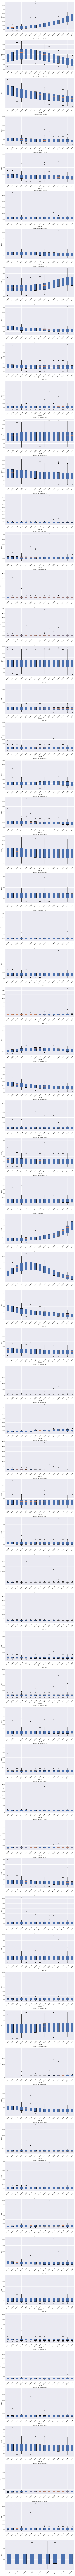

In [13]:
def boxPlot(df, hue):
    n_rows = (len(df.columns) + 1) // 2  # Number of rows
    n_cols = 2  # Number of columns
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
    for ax, col in zip(axes.flat, df.columns):
        sns.boxplot(data=df, x=col, y=hue, ax=ax)
        ax.set_title(f'Boxplot of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel(hue)
    plt.tight_layout()
    plt.show()

def plotGroupedBoxplot(signal):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a list to hold the data for each column
    data = [signal.iloc[:, i] for i in range(signal.shape[1])]
    
    # Generate positions for the boxplots along the x-axis
    positions = np.arange(1, signal.shape[1] + 1)
    
    # Create the grouped boxplot
    ax.boxplot(data, positions=positions, patch_artist=True, medianprops={'color': 'black'})
    
    # Set the x-axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels(signal.columns)
    ax.set_xlabel('Columns')
    
    # Set the y-axis label
    ax.set_ylabel('Values')
    
    # Set the plot title
    ax.set_title('Grouped Boxplot of Signal Columns')
    
    # Adjust the layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()


def plotBoxplotEveryXColumns(dataframe, x):
    num_cols = dataframe.shape[1]
    num_plots = num_cols // x + 1 if num_cols % x != 0 else num_cols // x

    fig, axes = plt.subplots(nrows=num_plots, figsize=(12, 6*num_plots))

    for i in range(num_plots):
        start_idx = i * x
        end_idx = start_idx + x
        subset = dataframe.iloc[:, start_idx:end_idx]
        
        ax = axes[i] if num_plots > 1 else axes
        ax.boxplot(subset.values, patch_artist=True)
        ax.set_xticklabels(subset.columns, rotation=45)
        ax.set_xlabel('Columns')
        ax.set_ylabel('Value')
        ax.set_title(f'Boxplot of Columns {start_idx+1} to {end_idx}')

    plt.tight_layout()
    plt.show()

#boxPlot(X, 'target')
signals = X.drop(['target'], axis = 1)
plotBoxplotEveryXColumns(signals, 15)

## Histograms

In [14]:
def histPlot(df, hue):
    n_rows = (len(df.columns) + 1) // 2  # Number of rows
    n_cols = 2  # Number of columns
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
    for ax, col in zip(axes.flat, df.columns):
        #print(df[col].value_counts())
        sns.histplot(data=df, x=col, hue = hue, kde=True, ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

#histPlot(X, 'target')

# Statistics

## From rows

In [15]:
from scipy.stats import kurtosis, skew

def extractingStatistics(df):

    stats_df = pd.DataFrame(columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])

    for i in range(len(df)):
        sample = df.iloc[i].values
        stats_df.loc[i] = [np.mean(sample), 
                           np.std(sample),
                           np.min(sample),
                           np.quantile(sample, 0.25),
                           np.quantile(sample, 0.5),
                           np.quantile(sample, 0.75),
                           np.max(sample),
                           skew(list(sample)),
                           kurtosis(list(sample))]
    return stats_df

stats_data = extractingStatistics(X)
stats_data['target'] = X['target']
stats_data

,mean,std,min,25%,50%,75%,max,skew,kurtosis,target
0,1525.942305,731.203920,1.0,982.6440,1323.24,1854.020,5718.68,2.405472,8.134007,1
1,1536.845304,741.511550,1.0,993.5375,1324.24,1871.335,5808.10,2.442026,8.397045,1
2,1538.924767,742.823801,1.0,996.2905,1326.28,1874.365,5886.35,2.444430,8.389582,1
3,1553.398834,745.163981,1.0,1006.5750,1342.23,1885.670,5710.68,2.434829,8.306814,1
4,1561.859051,744.877066,1.0,1016.7050,1357.91,1895.205,5762.47,2.444771,8.366095,1
...,...,...,...,...,...,...,...,...,...,...
15871,1802.145803,886.940527,0.0,1162.8300,1626.19,2112.790,6908.02,2.567742,8.921995,0
15872,1816.804552,893.586671,0.0,1174.2600,1646.88,2129.795,6811.89,2.553695,8.823714,0
15873,1824.229005,899.784504,0.0,1174.4900,1661.04,2138.085,6970.62,2.558095,8.891431,0
15874,1848.437724,910.436067,0.0,1191.8400,1675.35,2168.390,7120.41,2.579609,9.056354,0


## From features

In [16]:
def extractingFeatureStatistics(df):
    stats_df = pd.DataFrame(columns=['column', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])
    
    for column in df.columns:
        sample = df[column].values
        stats_df.loc[len(stats_df)] = [column,
                                       np.mean(sample),
                                       np.std(sample),
                                       np.min(sample),
                                       np.quantile(sample, 0.25),
                                       np.quantile(sample, 0.5),
                                       np.quantile(sample, 0.75),
                                       np.max(sample),
                                       skew(sample),
                                       kurtosis(sample)]
    return stats_df

stats_col = extractingFeatureStatistics(X)
stats_col['target'] = X['target']
stats_col


,column,mean,std,min,25%,50%,75%,max,skew,kurtosis,target
0,1611.19,2359.664520,307.790686,1655.480,2053.790,2429.70,2633.83,3154.12,-0.121839,-1.363346,1
1,1610.19,2398.277542,315.857441,1712.740,2088.640,2469.53,2678.64,3228.81,-0.114959,-1.370605,1
2,1609.18,2450.431755,326.863805,1714.850,2130.500,2523.75,2742.77,3322.69,-0.111363,-1.374078,1
3,1608.18,2508.277080,337.149222,1761.760,2177.320,2580.43,2809.36,3423.99,-0.112850,-1.378777,1
4,1607.17,2579.776994,351.892219,1808.650,2236.560,2659.49,2895.83,3490.42,-0.110293,-1.379949,1
...,...,...,...,...,...,...,...,...,...,...,...
1010,474.84,1043.924823,192.571364,661.983,849.710,1088.81,1197.50,1657.92,0.057144,-1.204877,1
1011,473.574,1048.551461,193.303726,667.747,855.427,1090.52,1203.13,1612.08,0.056926,-1.217416,1
1012,472.308,1047.564919,193.188390,677.458,853.242,1090.25,1202.83,1584.03,0.060025,-1.219615,1
1013,471.042,1047.500012,192.964015,663.469,853.032,1088.01,1202.54,1585.61,0.061680,-1.225185,1


## From target groups

In [17]:
def extractingGroupStatistics(df):
    grouped_data = df.groupby("target")
    
    group_stats = pd.DataFrame(columns=['target', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])

    for group_name, group_data in grouped_data:
        sample = group_data.iloc[:, :-3].values.flatten()
        group_stats.loc[len(group_stats)] = [group_name,
                                             np.mean(sample),
                                             np.std(sample),
                                             np.min(sample),
                                             np.quantile(sample, 0.25),
                                             np.quantile(sample, 0.5),
                                             np.quantile(sample, 0.75),
                                             np.max(sample),
                                             skew(sample),
                                             kurtosis(sample)]
    
    return group_stats


stats_group = extractingGroupStatistics(X)
stats_group

,target,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,0.0,1927.044217,996.904192,746.264,1296.25,1689.96,2255.54,28945.5,2.970004,12.886102
1,1.0,1632.416362,841.726674,649.429,1036.68,1426.16,1923.66,15188.2,2.659328,10.856355


# Peaks

In [18]:
from scipy.signal import find_peaks, peak_prominences, peak_widths


def findValidPeaks(x, peak_columns):
    loc, _ = find_peaks(x[peak_columns])
    prominences = peak_prominences(x[peak_columns], loc)[0]
    max_prom = np.max(prominences)
    others = np.delete(prominences, np.argmax(prominences))
    return loc, prominences, max_prom, others

def calculateWidth(x, peak_columns, loc, rel_height):
    width_data = peak_widths(x[peak_columns], [loc], rel_height=rel_height)
    return abs(float(peak_columns[int(width_data[3])]) - float(peak_columns[int(width_data[2])]))

def findValidPeaks(x, peak_columns):
    loc, _ = find_peaks(x[peak_columns])
    prominences = peak_prominences(x[peak_columns], loc)[0]
    max_prom = np.max(prominences)
    others = np.delete(prominences, np.argmax(prominences))
    return loc, prominences, max_prom, others

def calculateWidth(x, peak_columns, loc, rel_height):
    width_data = peak_widths(x[peak_columns], [loc], rel_height=rel_height)
    return abs(float(peak_columns[int(width_data[3])]) - float(peak_columns[int(width_data[2])]))

def extractValidPeaks(df, peak_columns, start_index, end_index, threshold=1/3):
    peak_columns = filterColumns(peak_columns, start_index, end_index)

    loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list = [], [], [], [], [], [], []

    for i in range(len(df)):
        x = df.loc[i, peak_columns]
        loc, prominences, max_prom, others = findValidPeaks(x, peak_columns)

        if not hasOutliers(others, max_prom, threshold):
            band_index = np.argmax(prominences)
            band = peak_columns[loc[band_index]]
            width_half = calculateWidth(x, peak_columns, loc[band_index], rel_height=0.5)
            width_full = calculateWidth(x, peak_columns, loc[band_index], rel_height=1.0)
            class_i = df.iloc[i, -1]

            loc_list.append(i)
            band_list.append(band)
            prom_list.append(max_prom)
            width_half_list.append(width_half)
            width_full_list.append(width_full)
            q_factor.append(max_prom / width_half)
            class_list.append(class_i)

    peaks = createPeaksDataFrame(loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list)
    return peaks

def filterColumns(peak_columns, start_index, end_index):
    start_index = max(start_index, 0)
    end_index = min(end_index, len(peak_columns) - 1)
    return peak_columns[start_index:end_index + 1]

def hasOutliers(others, max_prom, threshold):
    return np.where(others > max_prom * threshold)[0].any()

def createPeaksDataFrame(loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list):
    peaks = pd.DataFrame({
        'wave': np.array(loc_list, dtype=int),
        'band': np.array(band_list, dtype=float),
        'prominence': np.array(prom_list, dtype=float),
        'width_half': np.array(width_half_list, dtype=float),
        'width_full': np.array(width_full_list, dtype=float),
        'q_factor': np.array(q_factor, dtype=float),
        'target': np.array(class_list, dtype=int)
    })
    return peaks


peaks = extractValidPeaks(X, peak_columns = X.columns.tolist(), start_index=400, end_index=600)
peaks

,wave,band,prominence,width_half,width_full,q_factor,target
0,0,1081.36,4497.31,12.30,66.02,365.634959,1
1,1,1081.36,4595.25,13.42,79.38,342.418033,1
2,2,1081.36,4652.35,12.30,72.71,378.239837,1
3,3,1080.24,4472.76,12.30,80.49,363.639024,1
4,4,1082.48,4509.33,12.30,63.76,366.612195,1
...,...,...,...,...,...,...,...
15858,15871,1081.36,5380.45,13.42,75.93,400.927720,0
15859,15872,1081.36,5320.51,13.42,67.04,396.461252,0
15860,15873,1081.36,5448.87,13.42,57.06,406.026080,0
15861,15874,1081.36,5550.40,13.42,58.14,413.591654,0


# Feature importance

In [19]:
start_index = 400
end_index = 600
sample = X.iloc[:, start_index:end_index]
sample['target'] = X['target']
sample

,1191.95,1190.86,1189.76,1188.67,1187.58,1186.48,1185.39,1184.29,1183.2,1182.1,...,978.516,977.374,976.232,975.089,973.946,972.803,971.659,970.515,969.371,target
0,1458.55,1490.23,1558.46,1567.25,1669.69,1758.39,1853.89,1912.83,2031.08,2048.88,...,1046.43,1072.45,1056.88,1015.07,1010.45,1038.64,1079.94,1057.83,1075.060,1
1,1520.28,1501.66,1604.16,1633.51,1687.97,1710.43,1789.96,1924.24,1974.03,1989.56,...,1081.45,1043.99,1100.64,1023.82,1080.44,1080.19,1038.40,1066.57,1037.910,1
2,1485.99,1494.80,1542.46,1610.66,1703.96,1701.30,1840.19,1926.53,1994.56,1998.69,...,1096.78,1035.24,1050.31,1069.76,1038.89,1069.26,1027.47,1077.50,985.471,1
3,1527.14,1522.23,1567.60,1622.08,1726.80,1721.85,1858.46,1864.90,1976.31,2110.49,...,1068.32,1070.26,1070.01,1104.76,1076.07,1097.68,1044.96,1051.27,1059.760,1
4,1524.85,1554.23,1622.44,1708.90,1669.69,1733.27,1826.49,1839.79,2063.03,2060.29,...,1090.21,1083.39,1052.50,1113.51,1078.25,1082.38,1077.75,1075.31,1110.020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15871,1785.47,1773.65,1908.08,1957.92,2044.29,2160.30,2258.00,2248.37,2432.73,2482.39,...,1239.08,1190.63,1203.48,1196.64,1198.55,1182.96,1178.31,1230.49,1195.240,0
15872,1819.76,1844.51,1930.93,1935.08,1980.33,2105.50,2235.17,2264.35,2432.73,2512.05,...,1252.21,1214.71,1242.87,1262.27,1248.85,1255.12,1252.64,1204.26,1201.790,0
15873,1842.63,1867.36,1901.23,1923.66,2067.13,2116.92,2175.81,2325.98,2409.91,2514.33,...,1232.51,1238.79,1240.68,1271.02,1178.86,1198.27,1261.38,1239.23,1254.240,0
15874,1865.49,1844.51,1956.07,2012.76,2096.83,2162.59,2273.98,2456.09,2403.06,2530.30,...,1234.70,1184.07,1225.37,1251.33,1233.54,1259.49,1197.99,1263.27,1252.050,0


In [23]:
X.columns

Index([ 1611.19,  1610.19,  1609.18,  1608.18,  1607.17,  1606.17,  1605.16,
        1604.16,  1603.15,  1602.14,
       ...
        481.162,  479.898,  478.634,   477.37,  476.105,   474.84,  473.574,
        472.308,  471.042, 'target'],
      dtype='object', length=1015)

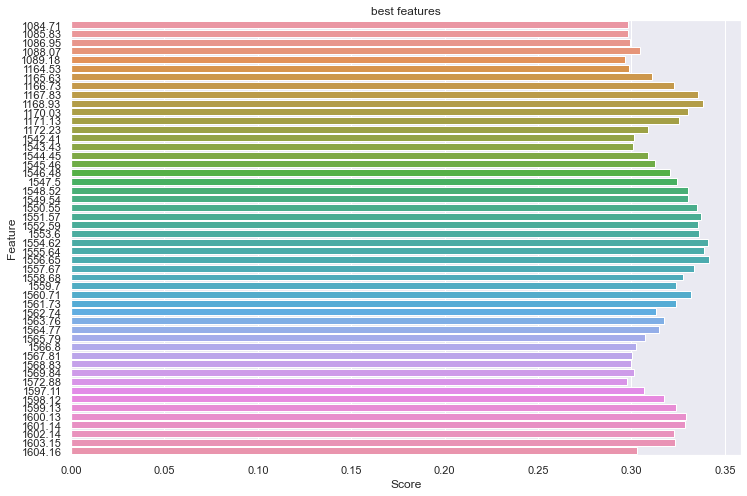

C:\Users\Lucas\AppData\Local\Temp\ipykernel_19056\295949384.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_best_df['target'] = sample['target']


In [36]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

def splitData(df, featureList, target):
    x = df.drop(featureList, axis=1)
    y = df[target]
    return x, y

def createEstimatorScoreDF(x, estimatorScore, sortedIdx):
    estimatorScoreDF = pd.DataFrame(estimatorScore[sortedIdx][::-1],
                                    index=x.columns[sortedIdx][::-1],
                                    columns=['score'])
    return estimatorScoreDF

def plotEstimatorScoreTopN(x, sortedIdx, estimatorScore, top_n, title):
    top_n_features = x.columns[sortedIdx[-top_n:]][::-1]
    top_n_scores = estimatorScore[sortedIdx[-top_n:]][::-1]

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x=top_n_scores, y=top_n_features, orient='h')
    ax.set(xlabel='Score', ylabel='Feature', title=title)
    plt.show()

def estimatorScoreTopN(x, y, top_n, title):
    estimatorScore = mutual_info_classif(x, y, random_state=42)
    sortedIdx = np.argsort(estimatorScore)
    estimatorScoreDF = createEstimatorScoreDF(x, estimatorScore, sortedIdx)
    plotEstimatorScoreTopN(x, sortedIdx, estimatorScore, top_n, title)
    return estimatorScoreDF

def selectKBestFeatures(k, estimatorScore, df):
    k_best = k
    k_best_features = estimatorScore.iloc[:k_best, :].index
    k_best_df = df[k_best_features]
    return k_best_df


#nWaves = 441
#nFeatures = 50

top_n = 50

X_sensor, y_sensor = splitData(X, ['target'], 'target')
estimator_scores_df = estimatorScoreTopN(X_sensor, y_sensor, top_n, f'best {top_n} features')

In [40]:
k_best_df = selectKBestFeatures(top_n, estimator_scores_df, X)
k_best_df['target'] = X['target']
k_best_df


C:\Users\Lucas\AppData\Local\Temp\ipykernel_19056\27589359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_best_df['target'] = X['target']


,1556.65,1554.62,1555.64,1168.93,1551.57,1553.6,1552.59,1167.83,1550.55,1557.67,...,1543.43,1567.81,1568.83,1086.95,1164.53,1084.71,1085.83,1572.88,1089.18,target
0,2441.59,2297.86,2330.34,1711.22,2323.43,2309.67,2328.85,1669.89,2300.82,2351.02,...,2238.48,2691.57,2687.21,3545.22,1534.65,4800.88,4170.96,2862.39,2657.88,1
1,2384.98,2354.44,2303.27,1749.91,2320.98,2282.61,2350.98,1744.97,2325.40,2424.88,...,2307.21,2728.58,2714.35,3558.65,1568.75,4890.36,4341.02,3017.98,2872.84,1
2,2372.67,2408.57,2404.16,1745.36,2281.64,2304.75,2314.09,1678.99,2288.53,2474.11,...,2304.76,2661.97,2724.22,3717.56,1602.85,4910.50,4327.59,2916.72,2772.08,1
3,2394.83,2339.68,2369.71,1722.60,2392.28,2412.97,2375.57,1688.09,2288.53,2434.73,...,2302.30,2679.23,2805.65,3675.03,1593.76,4863.52,4316.40,2948.83,2751.93,1
4,2340.68,2420.87,2431.23,1811.35,2360.31,2292.45,2368.19,1749.52,2271.32,2432.26,...,2250.76,2652.10,2647.73,3717.56,1568.75,4961.95,4327.59,2961.18,2742.97,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15871,2781.25,2861.25,2879.08,2216.40,2734.03,2791.77,2744.45,2159.03,2792.44,2956.63,...,2606.66,3308.34,3402.81,4653.10,1905.23,5874.70,5260.68,3605.77,3331.87,0
15872,2845.24,2812.05,2916.00,2161.79,2670.10,2868.02,2773.96,2072.58,2716.24,2939.40,...,2609.11,3468.70,3383.07,4646.39,1932.52,5852.33,5238.31,3726.79,3396.81,0
15873,2835.40,2804.66,2812.64,2298.32,2793.04,2745.03,2788.71,2149.93,2745.74,2927.09,...,2506.02,3485.97,3471.90,4718.01,1950.70,6111.84,5274.11,3707.03,3419.20,0
15874,2877.24,2743.16,2970.13,2257.36,2839.75,2828.66,2914.13,2170.41,2743.28,3013.25,...,2672.93,3485.97,3452.16,4655.34,2003.00,6002.22,5318.86,3734.20,3358.74,0


### Teste

NameError: name 'antigen' is not defined

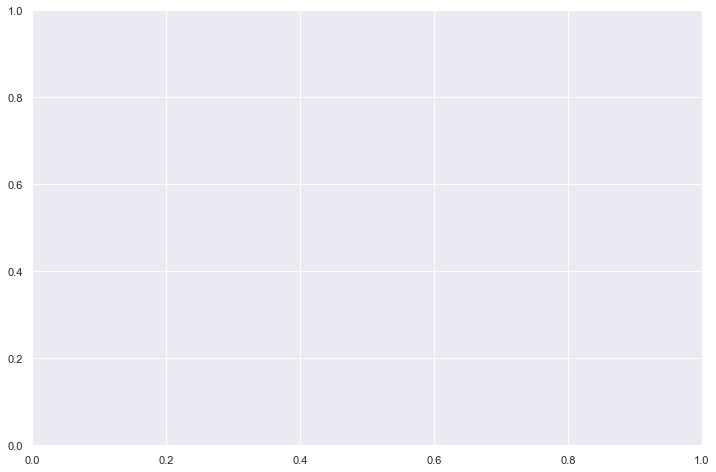

In [21]:
fig, ax = plt.subplots(1,1, figsize = (12,8))
antigenSpec = antigen[:1014]
controlSpec = control[:1014]
interferingSpec = interfering[:1014]

#spec2 = data[1014:2028]
plt.plot(antigenSpec[2], antigenSpec[3], '.r-', label = 'antigen')
plt.plot(controlSpec[2], controlSpec[3], '.g-', label = 'control')
plt.plot(interferingSpec[2], interferingSpec[3], '.b-', label = 'interfering')

#ax = plt.plot(spec2[2], spec2[3], '.b-')
ax.set(xlabel = 'comprimento da onda (1/cm)',
       ylabel = 'intensidade (u.a)',
       title = 'SERS')

plt.legend()
plt.show()

In [ ]:
# DataFrame de exemplo
data = {'Categoria': ['A', 'A', 'B', 'B', 'C', 'C'],
        'Valor': [10, 20, 30, 40, 50, 60]}
df = pd.DataFrame(data)

# Calcular a média dos valores para cada categoria
media_por_categoria = df.groupby('Categoria')['Valor'].mean()

print(media_por_categoria)


Categoria
A    15.0
B    35.0
C    55.0
Name: Valor, dtype: float64
